# 1. Import  libraries

In [14]:
%matplotlib inline

import pandas as pd 
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt 
import os
from scipy.stats.stats import spearmanr
from scipy.stats.stats import pearsonr


# 2. Change the working directory

In [15]:
os.chdir('/Users/neda/Dropbox (PopGen)/tmp/egg_size_method_paper/scripts/')
os.getcwd()

'/Users/neda/Dropbox (PopGen)/tmp/egg_size_method_paper/scripts'

# 3. Read the input file

### The eggs were sorted in three 96-well plates using Biosorter. Manual measurements are performed in ImageJ. 

### The columns in this dataset are 'Row', 'Column', 'plate', 'TOF', 'Size', ''Length'. 

### 'Row' and 'Column' correspond to the row and column on the 96-well plate. 'plate' refers to the number of 96-well plate. 'TOF' is the time-of-flight measurement from large particle flow cytometry. 'Size' is the estimated size using 'TOF'. You can refer to section Reference beads for the details of the conversion. 'Length' is the manually measured egg length using ImageJ. The units of 'Size' and 'Length' are in μm.


In [16]:
all_bio_man_flt4 = pd.read_csv('../data/github/biosorter_plus_manual_measurement_3plates.csv')


# 4. Correlation of Biosorter size estimates and manual measurements 

Text(0, 0.5, 'Egg size - automated measurement ($\\mu$m)')

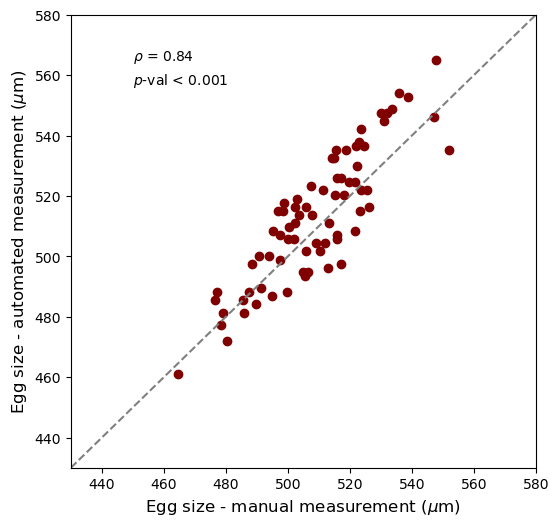

In [17]:
#fit a linear model to the data
x = np.array(all_bio_man_flt4['Length']).reshape((-1, 1))
x.shape
y = np.array(all_bio_man_flt4['Size'])
y.shape

model = LinearRegression(fit_intercept = False).fit(x, y)
sl=model.coef_[0]
intc =  model.intercept_ 

#plot data
fig , ax = plt.subplots(sharex=True, sharey=True,figsize=(6,6),dpi=100, facecolor='w', edgecolor='k')    
plt.scatter(all_bio_man_flt4['Length'], all_bio_man_flt4['Size'],marker='o', color='maroon')
plt.xlim(430,580)
plt.ylim(430,580)
plt.axline((450,450), (570,570), color = 'gray', linestyle='--')
plt.annotate(r'$\rho$ = %.2f'%(np.round(spearmanr(all_bio_man_flt4['Size'],all_bio_man_flt4['Length'])[0],2)), xy=(450,565),fontsize=10)
plt.annotate('$\it{p}$-val < 0.001', xy=(450,557),fontsize=10)
plt.xlabel('Egg size - manual measurement ($\mu$m)', fontsize=12) 
plt.ylabel('Egg size - automated measurement ($\mu$m)', fontsize=12)
plt.savefig('../plots/final_plots/R12R13_manual_biosorter_size_correlation_revision.png', dpi=100,format='png', bbox_inches = 'tight')
plt.savefig('../plots/final_plots/R12R13_manual_biosorter_size_correlation_revision.svg', dpi=100,format='svg', bbox_inches = 'tight')
